<a href="https://colab.research.google.com/github/Schiessl/AgoraVAI/blob/main/Compara_CDI_e_Ativos_da_bolsa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando Bibliotecas

In [1]:
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from datetime import date, datetime, timedelta

import matplotlib
matplotlib.rcParams['figure.figsize'] = (16,8)

!pip install yfinance --upgrade --no-cache-dir
import yfinance as yf
import time
import matplotlib.dates as mdates
import seaborn as sns
# Handle date time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 180.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 152.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 158.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
  

# Funções para execução dos procedimentos

## Download via API do Banco Central do Brasil

http://api.bcb.gov.br/dados/serie/bcdata.sgs.432/dados?formato=json 

URL da api - basta mudar o número para acessar a série

https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries

Link principal das séries disponíveis no BC

In [2]:
def consulta_bc(codigo_bcb, data_inicio):
  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
  df = pd.read_json(url)
  df['data'] = pd.to_datetime(df['data'], dayfirst=True)
  df = df[df['data'] >= data_inicio]
  df.set_index('data', inplace=True)
  return df

## Define datas

In [3]:
# Define período para consulta
def define_periodo(anos):
  dias_dif = 365.2*anos
  today = date.today()
  data_hoje = today.strftime("%d/%m/%Y") # data de hoje em formato brasileiro
  date_today = today.strftime("%Y-%m-%d")  # data de hoje em formato brasileiro
  inicio = datetime.now() + timedelta(days=(-dias_dif)) # data inicial volta para X anos atrás
  data_inicio = inicio.strftime("%d/%m/%Y")  # data de hoje em formato brasileiro
  date_start = inicio.strftime("%Y-%m-%d") # data de hoje em formato americano
  return(data_inicio)

## Baixando ativo

In [4]:
# O período carregado é o existente na base do yahoo
def download_stock(stock):
  ticker = stock
  ativo = yf.download(tickers=ticker)[['Adj Close']] # Baixa ativo
  return ativo

## Tratamento das séries

In [5]:
def tratar_data_inicio(anos, ativo_retorno):
  data_inicio = define_periodo(anos) # função de definição de período
  # Define a data mais antiga do ativo
  data_in = ativo_retorno.index.min().strftime("%d/%m/%Y")
  # Transforma a data para o formato data para possibilitar a comparação entre datas
  date_str_in = data_in
  date_in = datetime.strptime(date_str_in, '%d/%m/%Y').date()
  date_str_inicio = data_inicio
  date_inicio = datetime.strptime(date_str_inicio, '%d/%m/%Y').date()
  # Pegando as data mais antiga de CDI e do Ativo
  if date_inicio < date_in:
    data_inicio = data_in
  else:
    data_inicio = data_inicio
  # Alterar formato para compatibilidade
  data_inicio = datetime.strptime(data_inicio, '%d/%m/%Y').date()
  data_inicio = data_inicio.strftime('%m/%d/%Y')
  return(data_inicio)

## Mostrar o resultado

In [6]:
def graf(ticker, anos):
  ativo = download_stock(ticker)
  ativo_retorno = ativo.pct_change() # Calcula retorno
  data_inicio = tratar_data_inicio(anos, ativo_retorno) # Estabelece o histórico para recuperar em anos
  cdi = consulta_bc(12,data_inicio) # Baixa o histórico do CDI

  # Acumulando retornos
  ativo_retorno_acumulado = (1 + ativo_retorno[ativo_retorno.index >= data_inicio]).cumprod()
  ativo_retorno_acumulado.iloc[0] = 1
  cdi_acumulado = (1 + cdi[cdi.index >= data_inicio] / 100).cumprod()
  cdi_acumulado.iloc[0] = 1

  # Utilizar o grid branco do seaborn
  sns.set(font_scale=1.0, style="whitegrid")
  # Gráfico de comparação entre CDI e ativos da bolsa
  ticker = ticker.replace('.SA', '')
  titulo = 'CDI' + ' x ' + ticker
  
  data_ini = cdi_acumulado.index.min().strftime('%Y-%m-%d') # Data para o cálculo
  data_fim = cdi_acumulado.index.max().strftime('%Y-%m-%d')

  my_dpi=96 
  plt.rcParams["figure.figsize"] = [(96*20)/my_dpi, (96*8)/my_dpi] # tamanho genérico

  fig, ax = plt.subplots()
  ax.plot(cdi_acumulado, label='CDI')
  ax.plot(ativo_retorno_acumulado, label=ticker)
  ax.legend(loc="upper left")

  dt_ini = cdi_acumulado.index.min().strftime('%d/%m/%Y') # Data para o print no gráfico
  dt_fim = cdi_acumulado.index.max().strftime('%d/%m/%Y')

  plt.suptitle(titulo, fontsize=18)
  plt.title('Período: ' + str(dt_ini) + ' -- ' + str(dt_fim), fontsize=14)

  # Define the date format
  date_form = DateFormatter("%m-%Y")
  ax.xaxis.set_major_formatter(date_form)
  ax.set(xlim=[data_ini, data_fim])
  ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
  plt.xticks(rotation=45)

  # Valor resultante de $1,00 aplicado no início do período
  print('CDI: ' , *cdi_acumulado.iloc[-1:,-1:].values, '   ', ticker,': ', *ativo_retorno_acumulado.iloc[-1:,-1:].values, '   ', ticker,'/', 'CDI: ', "%.02f%%" % ((float(((ativo_retorno_acumulado.iloc[-1:,-1:].values) / (cdi_acumulado.iloc[-1:,-1:].values)-1)*100))))
  return 

#Mostrar Resultado

[*********************100%***********************]  1 of 1 completed
CDI:  [1.36125041]     DIVO11 :  [1.69964665]     DIVO11 / CDI:  24.86%


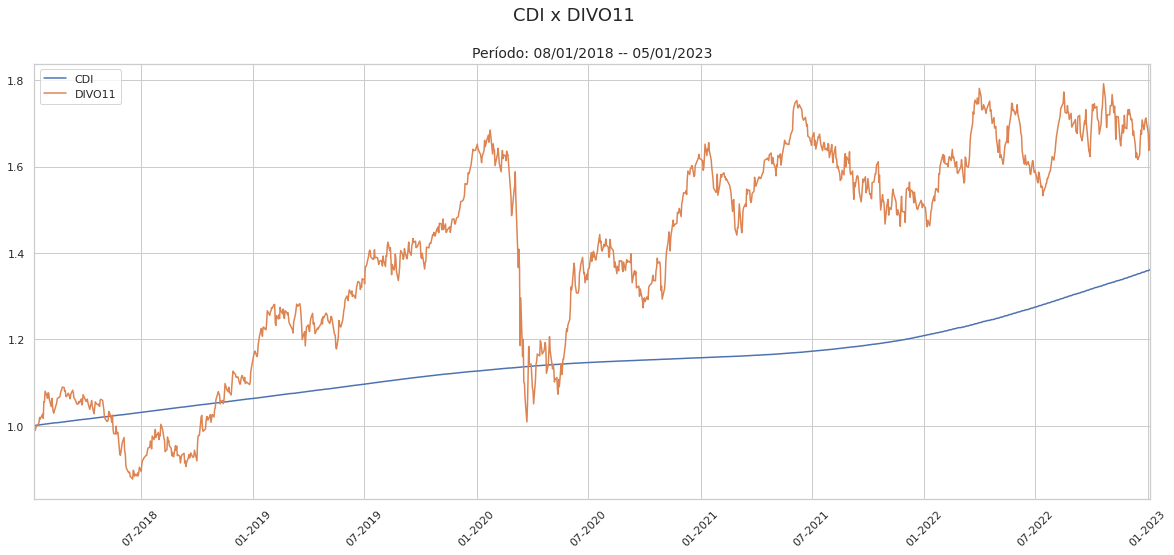

In [7]:
# Códigos BCB relevantes: 12 (SELIC)
# Códigos ETF relevantes: BOVA11.SA, XFIX11.SA, DIVO11.SA
# Ativos = ['^BVSP','BBAS3',	'BBSE3',	'ABEV3',	'KLBN3',	'ITSA4',	'PETR4', 'VALE3', 'PRIO3', 'BBDC4']
# ticker = 'ITSA4.SA' # Não esquecer de colocar '.SA'

graf('DIVO11.SA', 5)